# ASTRON C161 Final Project
---

In [1]:
import numpy as np
from scipy import constants as consts
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Simulation', artist='Matplotlib',comment='Oh my')
writer = FFMpegWriter(fps=15, metadata=metadata)

## 1) Setting Up
---

### 1.1: Defining constants

In [2]:
# Constants
G = consts.G
c = consts.c
solar_radius = 6.957e8
solar_mass = 1.989e30
stellar_radius = solar_radius
stellar_mass = solar_mass
bh_mass = 4.1e6*stellar_mass # Mass of SMBH Sagittarius A
bh_mass = 5*solar_mass
N_swarm = 10000 # number of swarm particles
ms = stellar_mass/N_swarm

### 1.2: Useful functions + classes

In [3]:
def to_cart(r, theta, convert=True):
    '''Convert set of polar coordinates to cartesian
    The conversion parameter automatically assumes 
    that you need to convert the pixel units
    and will divide the r values by 3e8'''
    global conversion
    if convert:
        r = np.copy(r)
        r/=conversion
    return r*np.cos(theta), r*np.sin(theta)

def to_polar(x, y):
    '''Convert polar coordinates to cartesian'''
    return np.sqrt(x**2 + y**2), np.arctan(y/x)

def sch_radius(M):
    '''Calculate the schwarzchild radius for a given M mass black hole'''
    global G, c
    return 2*G*M / c**2

def tidal_radius(m, M, r_star):
    '''Calculate the tidal radius, given a star and a black hole'''
    return (M/m)**(1/3) * r_star

def calc_dr_dtau(E, L, r, m=stellar_mass, M=bh_mass):
    '''Calculate dr/dtau'''
    global N_swarm
#     m /= N_swarm
    rs = sch_radius(M)
    p1 = E**2 / (m**2 * c**2)
    p2 = (L**2 / (m**2 * r**2)) * (1-(rs/r))
    p3 = c**2 * (1-(rs/r))
    return (p1-p2-p3)**(0.5)

def EN(E, ms=ms):
    global c
    return ((E/(ms*c**2))**2 - 1) * ms*c**2 / 2

def calc_dr_dtau_2(en, ms, M, rs):
    global G
    return np.sqrt(2*(en+(G*M*ms/rs))/ms)

def energy(v, r, m, M):
    '''Calculate the Lagrangian'''
    global G
    return 0.5*m*v**2 - (-G*M*m/r)
    
def ang_momentum(m, v, b):
    return m*v*b

def scale_up(rs):
    global conversion
    return np.copy(rs) * conversion

## 2) Initialization of Variables
---

Get the tidal radius via $r_T = (\frac{M_{\text{bh}}}{M_{\text{star}}})^{1/3} R_{\text{star}}$

In [4]:
dtau = 50
rt = tidal_radius(stellar_mass, bh_mass, stellar_radius)
conversion = rt/3 + (0.1*rt/3) # One graphpixel corresponds to this many meters, which was calculated based on the tidal radius

Swarm initiation

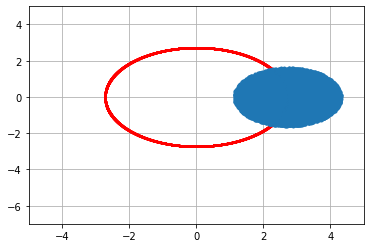

In [5]:
b = rt # + (0.1*rt) # impact parameter, a little bigger than tidal radius
swarm = np.random.uniform(rt-stellar_radius, rt+stellar_radius, N_swarm-1)
r = b

# Initial coordinates of the star in cartesian (b/c it's easier to work with)
np.random.seed(2023)
rs = np.append(b, swarm) # an array of starting radius (r) positions
y_dis = 0 # y displacement
init_xs = rs/conversion
init_ys = np.random.uniform(-stellar_radius/conversion-y_dis, stellar_radius/conversion-y_dis, N_swarm)
# init_ys = rs/conversion
# init_xs = np.random.uniform(-stellar_radius/conversion, stellar_radius/conversion, N_swarm)

# Edit the star so that it's a circle, like in Burkhard's class
circle = lambda x, y, r: np.sqrt((x-(rt/conversion))**2 + (y+y_dis)**2) <= r
idxs = np.where(circle(init_xs,init_ys,stellar_radius/conversion))[0]
init_xs = init_xs[idxs]
init_ys = init_ys[idxs]

rt_phis = np.linspace(0, 2*np.pi, 100000)
rt_rs = np.ones(100000)*rt
xx, yy = to_cart(rt_rs, rt_phis)
plt.plot(xx, yy, '.', color='red', markersize=1)

rs, phis = to_polar(init_xs, init_ys)
rs = scale_up(rs)
plt.plot(init_xs, init_ys, '.')
plt.ylim(-7,5)
plt.xlim(-5,5)
plt.grid(True)

### 2.1: Angular momentum and $\frac{d\phi}{d\tau}$
* Solving the Schwarzchild metric in terms of $\frac{dr}{d\tau}$, we get:
    * $\frac{dr}{d\tau} = [\frac{E^2}{m^2c^2} - \frac{L^2}{m^2r^2}(1-\frac{r_s}{r}) - c^2(1-\frac{r_s}{r})]^{1/2}$
* At the impact parameter b, the energy E of the middle of the star is defined as zero and $\frac{dr}{d\tau} = 0$, so the equation becomes
    * $0 = \frac{L^2}{m^2r^2}(1-\frac{r_s}{r}) - c^2(1-\frac{r_s}{r})$
    * Which turns into: $L = mcr$

In [6]:
m = stellar_mass
M = bh_mass
b = rt # + (0.1*rt) # impact parameter, a little bigger than tidal radius
v = np.sqrt(G*M/rs)

L = ang_momentum(m,v,rs)

dphi_dtau = L / (m*rs**2)
dphi = dphi_dtau * dtau
dphi

array([0.03041131, 0.01819929, 0.02594806, ..., 0.01702489, 0.02087891,
       0.02175838])

This is the constant of motion L for the point of the star AT THE TIDAL RADIUS. It assumes that E = 0. This is only true, of course, at the tidal radius, where we define that E = 0.

In [7]:
mm = ms
L = -((G*M*mm/rt) - (mm*c**2/2)) / ((1/(2*mm*rt**2)) - (G*M/(rt**3*mm*c**2)))
L**0.5

7.093612991749633e+43

### 2.2: Energy and $\frac{dr}{d\tau}$

In [8]:
r = b
E = energy(v, rs, m, M)
E = (m/N_swarm) * c**2
dr_dtau = calc_dr_dtau(E, L, rs)
0.5*m*(v/rs)**2 - G*M*m/rs, E**2/((m/N_swarm)**2 * c**2)
# E**2 /( m**2 * c**2)

/var/folders/44/p2_ff2f90sl05kvyytv51rq00000gn/T/ipykernel_23105/2846508123.py:33: RuntimeWarning: invalid value encountered in sqrt
  return (p1-p2-p3)**(0.5)


(array([-1.08647198e+42, -7.71551273e+41, -9.77383568e+41, ...,
        -7.37991433e+41, -8.45539126e+41, -8.69119519e+41]),
 8.987551787368174e+16)

In [9]:
E = ms*c**2 #+ 0.5*ms*v**2 - G*M*ms/rs
en = EN(E)
dr_dtau = calc_dr_dtau_2(en, ms, M, rs) * -1
dphi_dtau
E

1.78762405050753e+43

### 2.3: Acceleration of the angular component $\frac{d^2\phi}{d\tau ^2}$
* Solution using the Lagrangian derivative: $4r(\frac{dr}{d\tau})(\frac{d\phi}{d\tau}) + r^2\frac{d^2\phi}{d\tau ^2}=0$
    * $\frac{d^2\phi}{d\tau ^2}=-\frac{4}{r}(\frac{dr}{d\tau})(\frac{d\phi}{d\tau})$

In [10]:
acc_phi = dr_dtau * dphi_dtau * -4 * dtau**2 / rs  # acceleration in the angular direction

### 2.4: Conversion between dt and dtau
* $\frac{E}{m} = (1-\frac{r_s}{r})c^2\frac{dt}{d\tau}$

In [11]:
r_sch = sch_radius(bh_mass)
dt_dtau = E/(ms*(1-(r_sch/rs))*c**2)
print('The max value of dt/dtau is {:.6f}, thus we will approximate that dt is approximately dtau'.format(max(dt_dtau)))

The max value of dt/dtau is 1.000030, thus we will approximate that dt is approximately dtau


### 2.5: Acceleration of the radial component $\frac{d^2 r}{d\tau^2}$
* Equation of motion solution using the Lagrangian: $\frac{d^2 r}{d\tau^2} = \frac{d^2\phi}{d\tau ^2}r\alpha + \frac{r_s (\frac{dr}{d\tau})^2}{2r^2\alpha} + \frac{c^2r_s\alpha}{2r^2} - \frac{GMm\alpha}{2r^2} - \frac{(\frac{dr}{d\tau})^2 r_s}{\alpha r}$

In [12]:
r_sch = sch_radius(bh_mass)
alpha = ((r_sch/rs)-1)

p1 = acc_phi*rs*alpha
p2 = r_sch * dr_dtau**2 / (2*rs**2 * alpha)
p3 = c**2 * r_sch * alpha / (2*rs**2)
p4 = G*M*ms*alpha / (2*rs**2)
p5 = dr_dtau**2 * r_sch / (alpha*rs)
acc_r = p1 + p3 - p4
acc_r

array([4.47050402e+28, 2.25450159e+28, 3.61784559e+28, ...,
       2.06264157e+28, 2.70762191e+28, 2.86074728e+28])

## 3) Test simulation with only $\frac{d\phi}{d\tau}$

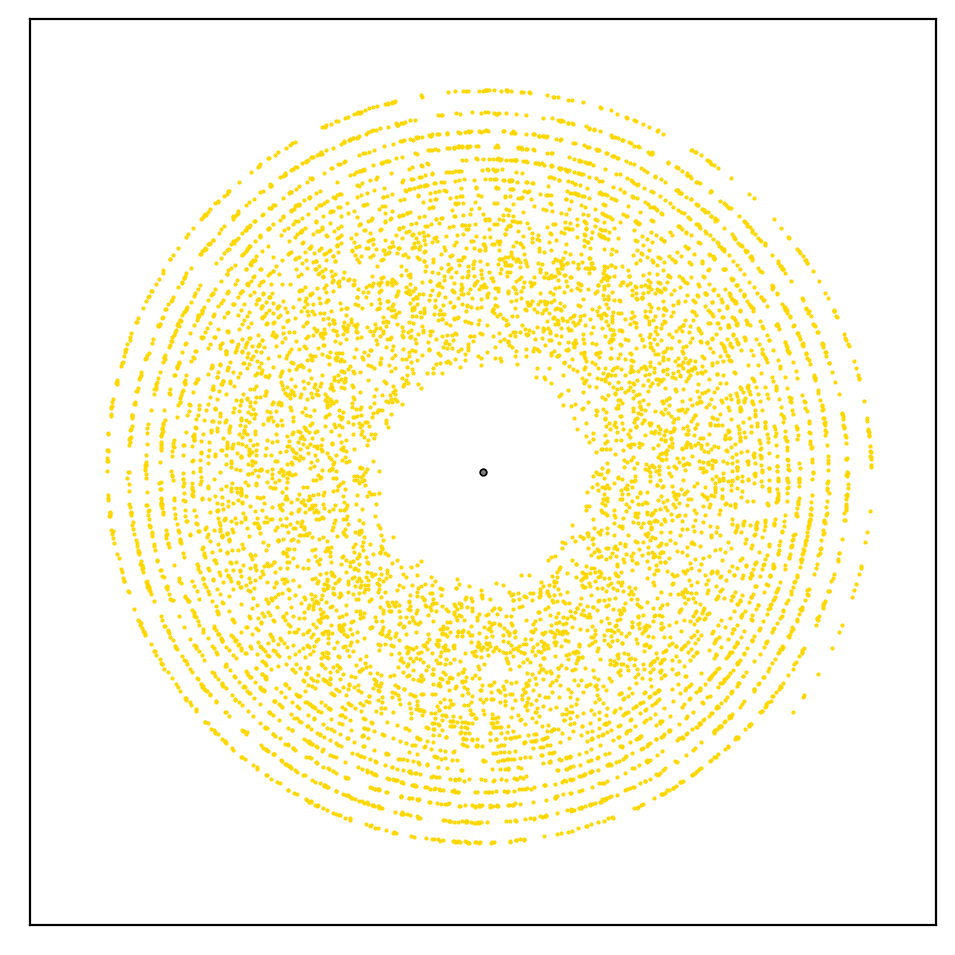

In [13]:
fig = plt.figure(figsize=(12.,6.), dpi=200)
iterations = 200
view = 5

# Tidal radius circle
rt_phis = np.linspace(0, 2*np.pi, 100000)
rt_rs = np.ones(100000)*rt
xt, yt = to_cart(rt_rs, rt_phis)

r_sch_phis = np.linspace(0, 2*np.pi, 100000)
r_sch_rs = np.ones(100000)*3*sch_radius(bh_mass)
xsch, ysch = to_cart(r_sch_rs, r_sch_phis)

with writer.saving(fig, str(datetime.now()) + ".mp4", dpi=200):
    for i in range(iterations):
        # Update graph
        plt.clf()
        x, y = to_cart(rs, phis)
        plt.plot(x, y, '.', markersize=1, color='gold')
        plt.plot(0, 0, '.', markersize=4, color='black')
        # Tidal radius
#         plt.plot(xt, yt, '.', color='red', markersize=1)
        plt.plot(xsch, ysch, '.', color='gray', markersize=0.5)
        plt.xlim(-view,view)
        plt.ylim(-view,view)
        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        # Update coordinates
        phis += dphi
        v = np.sqrt(G*M/rs)
        
        # --------------------
        E = energy(v, rs, m, M)
        
        en = EN(ms*c**2 - 0.5*ms*v**2)
        dr_dtau = calc_dr_dtau_2(en, ms, M, rs)
        dr = dr_dtau * dtau
        # --------------------
        
        dphi += acc_phi
        
        # Update animation
        writer.grab_frame()

In [14]:
rt, 3*sch_radius(bh_mass)/conversion

(1189630266.102978, 0.00010158671584038188)

In [15]:
r_sch/conversion

3.3862238613460623e-05

In [16]:
xt

array([2.72727273, 2.72727272, 2.72727271, ..., 2.72727271, 2.72727272,
       2.72727273])

In [17]:
xsch

array([0.00010159, 0.00010159, 0.00010159, ..., 0.00010159, 0.00010159,
       0.00010159])

```python
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig = plt.figure(figsize=(12.,6.), dpi=200)

with writer.saving(fig, "test2.mp4", dpi=200):
    for i in range(len(r)):
        plt.clf()
        x, y = cart(r[i], theta[i])
        plt.plot(x, y, '.')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.grid(True)
        writer.grab_frame()
```